# Spatial autocorrelation and GWR

In this notebook I will explore the existence of spatial autocorrelation in the ASC dataset and fit a **Geographically Weighted Regression** model (GWR) to predict, once again, the number of pickups.

Spatial models are designed to

* Morgan´s index

In [154]:
import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd

%matplotlib inline

In [6]:
# Polygons of blocks in New York.
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

#socioeconomic data
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)
block_acs = acs.pivot(index = "geoid", columns = "acs_demog_var" ).droplevel(level = 0, axis = 1)

#number of pickups per block
pickup_counts = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col = 0)

## Inputting missing data from neighbor blocks: spatial self join

Like the last time, we input the missing values using the neighbor blocks, which will **more likely be similar** to the current missing one.

We perform a **spatial self join** to find the neigbors, which is more efficient than computing the intersection of each pair of blocks. Since colindant blocks apparently do intersect upscaling the polygons is no longer needed.

In [117]:
intersections = gpd.sjoin(nymap, nymap, how = "inner", op = "intersects")
neighbors = intersections.groupby("geoid_left")["geoid_right"].apply(list)
neighbors = gpd.GeoDataFrame(neighbors)
_ = neighbors.apply(lambda x: x["geoid_right"].remove(x.name), axis=1)
neighbors["number_neighbors"] = neighbors.apply(lambda x: len(x[0]),axis = 1)

In [130]:
def input_from_neighbors(df, columns_to_input, neighbors_df):
    data = df.copy()
    for column_name in columns_to_input:
        #We find which rows are misisng values 
        rows_missing_values = data[data[column_name].isna()].index
        for geoid in rows_missing_values:
            neighbors = neighbors_df.loc[geoid]["geoid_right"] #we search for neighbors of geoid
            median_value_neighbors = data[column_name].loc[neighbors].median() #we compute here the median of neighbors
            data.loc[geoid][column_name] = median_value_neighbors
    return data

In [153]:
# Drops features and checks that no longer are there missing values
block_acs.drop(["aggregate_travel_time_to_work", "owner_occupied_housing_units_median_value"], axis = 1, inplace = True)

columns_to_input = ["income_per_capita","median_age", "median_income","median_rent", "median_year_structure_built", "renter_occupied_housing_units_paying_cash_median_gross_rent"]
count = 0
while(block_acs.isna().sum().sum() > 0 and count < 5):
    block_acs = input_from_neighbors(block_acs, columns_to_input , neighbors)
    count +=1

#There are some blocks (4) which do not have neighbors (islands). We input the median of all blocks for their missing values
median_values = block_acs.median(axis = 0).to_dict()
block_acs = block_acs.fillna(value = median_values)
print(block_acs.isna().sum().sum())

0


We define a **geodataframe** joining the polygons and the number of pickups together with the block ACS data

In [169]:
pickups_per_day_per_block = pd.read_csv("./files/pickups_per_day_per_block.csv", index_col=0)
pickup_counts = pickups_per_day_per_block["total"]

#model_data = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True, how = "inner" )

In [188]:
# merge ACS and pickups
df = pd.merge(block_acs,pickup_counts, right_index = True, left_index = True, how = "left" )
# merge result with nymap polygons
df = pd.merge(df,nymap, left_index = True, right_on = "geoid")
df.rename(columns = {"total" : "pickups", "renter_occupied_housing_units_paying_cash_median_gross_rent" : "renter_cash_payers"}, inplace = True)
gdf = gpd.GeoDataFrame(df, geometry = "geometry")
gdf.pickups.fillna(0, inplace = True) # We set 0 pickups for the blocks which dont have data

<AxesSubplot:title={'center':'Number of pickups per block'}>

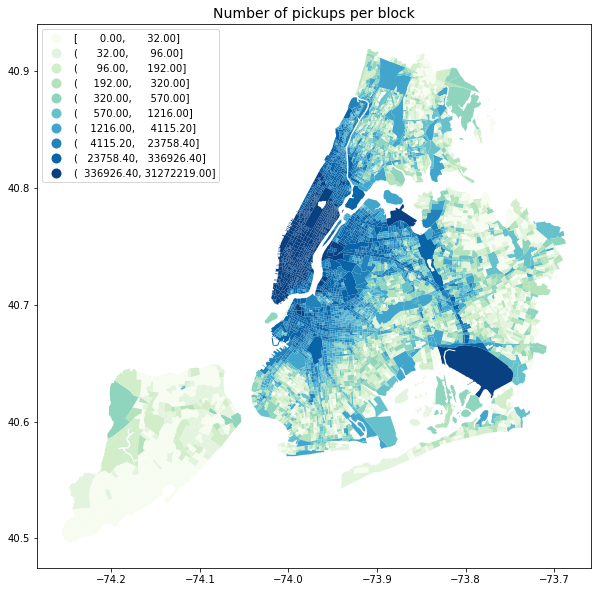

In [205]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})
ax.set_title("Number of pickups per block", fontdict={"fontsize" : 14})
gdf.plot(column='pickups', scheme='Quantiles', k=10, cmap='GnBu', legend=True, ax=ax, legend_kwds ={"loc": "upper left" })

## Spatial autocorrelation

We first selec
Queen weights
Global autocorrelation -> Lag Moran index
Local autocorrelation Local moran index

Explain difference global local


In [206]:
import libpysal as lps
from pysal.model import mgwr
import esda

In [213]:
gdf.set_index("geoid", inplace = True)

In [219]:
target = gdf['pickups']
queen_weights =  lps.weights.Queen.from_dataframe(gdf) #another (faster?) way to compute the neighbors for each block
queen_weights.transform = 'r'
lag_pickups = lps.weights.lag_spatial(queen_weights, target) # returns the average pickups of each block´s neighbors

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1130, ' is an island (no neighbors)')
('WARNING: ', 3223, ' is an island (no neighbors)')
('WARNING: ', 4165, ' is an island (no neighbors)')


/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 4 islands with ids: 0, 1130, 3223, 4165.
  warnings.warn(message)


In [235]:
mi = esda.moran.Moran(target, queen_weights)
mi.I

0.5343654845710382

In [229]:

li = esda.moran.Moran_Local(target, queen_weights)


ValueError: cannot reshape array of size 0 into shape (0)

In [ ]:
from splot.esda import moran_scatterplot



In [ ]:

fig, ax = moran_scatterplot(li, p=0.05)
ax.set_xlabel('Price')
ax.set_ylabel('Spatial Lag of Price')
plt.show()

In [ ]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(li, san_diego, 'median_home_value')